<a href="https://colab.research.google.com/github/mrreyesm/SECOM/blob/main/SECOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SECOM: The Semiconductor Manufacturing process dataset

##Setting environment

In [ ]:
#Importing Librarys 
#For the creation of dataframes and manipulating data
import pandas as pd
from pandas.api.types import is_numeric_dtype
# For numerical processing
import numpy as np
# For statistical analysis
import statistics
# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Stats
from scipy.stats import shapiro
# Iterable tools
from itertools import combinations
# For splitting data
from sklearn.model_selection import train_test_split
# For interactivity
from ipywidgets import interactive

##Loading Data

In [ ]:
# Creates a dataframe with the features of the SECOM dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
secom_features = pd.read_csv(url, sep = ' ', header = None)
# Gives names to the columns according to their position in the dataset
secom_features.columns = ["FEATURE_"+str(col+1) for col in
                          range(0,len(secom_features.columns))]
# Creates a dataframe with the labels of the SECOM dataset and gives a col name
url="https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
secom_labels = pd.read_csv(url, sep = " ", header = None)
secom_labels.columns = ("STATUS", "TIMESTAMP")
# Changes timestamp column to datetime format
secom_labels['TIMESTAMP'] =  pd.to_datetime(secom_labels['TIMESTAMP'])
# Merges both datasets through the index
secom_data = pd.merge(secom_labels, secom_features, left_index=True,
                      right_index=True)

##EDA: Exploratory Data Analysis

In [ ]:
# Overall information of dataset
print("START DATE: ", secom_data["TIMESTAMP"].min(),
      "\nEND DATE:   ",secom_data["TIMESTAMP"].max(),
      "\nNUMBER OF RECORDS:   ",len(secom_data.index),
      "\nNUMBER OF FEATURES:   ",len(secom_data.columns)
      )

START DATE:  2008-01-08 02:02:00 
END DATE:    2008-12-10 18:47:00 
NUMBER OF RECORDS:    1567 
NUMBER OF FEATURES:    592


In [ ]:
# Create function that describes each column
def descriptive_statistics(df):
  #Creates empty target dataframe
  col_names = ["FEATURE", "COUNT", "SUM",  "MEAN", "MIN", "Q1", "MEDIAN",
             "Q3", "MAX", "VARIANCE", "STANDARD_DEV", "UNIQUE_VALUES",
             "MISSING_VALUES", "PERCENTAGE_NA", "OUTLIERS_3S", "PERCENTAGE_O3S",
             "P_VALUE","TEST_RESULT", "NORM_STD"
             ]
  descriptive_df = pd.DataFrame(columns=col_names)
  # Only for numeric values
  df = df.select_dtypes(include=['int64','float64'])
  # Iterates through each column
  for col, col_name in enumerate(df.columns):
    num_values = df[col_name].count()
    sum = df[col_name].sum()
    # Central tendency
    mean = df[col_name].mean()
    min = df[col_name].min()
    q1 = df[col_name].quantile(0.25)
    median = df[col_name].quantile(0.50)
    q3 = df[col_name].quantile(0.75)
    max = df[col_name].max()
    # Volatility
    var = df[col_name].var()
    std = df[col_name].std()
    unique = df[col_name].nunique()
    missing = df[col_name].isnull().sum()
    percentage_na = df[col_name].isnull().sum() * 100 / len(df[col_name])
    # Outlier identification with zscore
    zscores = (df[col_name]-mean)/std
    zscores = zscores.to_frame()
    zoutliers = zscores.query(f"{col_name} > 3 or {col_name} < -3")
    outliers = zoutliers[col_name].count()
    perc_out = (outliers/num_values)*100
    # Normality distribution test
    stat, normality_p = shapiro(df[col_name])
    alpha = 0.5
    if normality_p > alpha:
      #Sample looks Gaussian (fail to reject H0)
      test_result = "NORMAL"
    else:
      #Sample does not look Gaussian (reject H0)
      test_result = 'NOT NORMAL'
    # Min - Max normalization
    temp = (df[col_name] - min)/ (max - min)
    std_norm_values = temp.std()
    # Creates a list wirh all the values and concatenates it to target df
    desc = [col_name, num_values, sum,  mean, min, q1, median, q3,
           max, var, std, unique, missing, percentage_na, outliers,
           perc_out, normality_p, test_result, std_norm_values]
    df_length = len(descriptive_df)
    descriptive_df.loc[df_length] = desc
  return descriptive_df

# Apply function
features_descriptives = descriptive_statistics(secom_data)
features_descriptives.head(5)

,FEATURE,COUNT,SUM,MEAN,MIN,Q1,MEDIAN,Q3,MAX,VARIANCE,STANDARD_DEV,UNIQUE_VALUES,MISSING_VALUES,PERCENTAGE_NA,OUTLIERS_3S,PERCENTAGE_O3S,P_VALUE,TEST_RESULT,NORM_STD
0,STATUS,1567,-1359,-0.867262,-1,-1.0000,-1.0000,-1.0000,1,0.248014,0.498010,2,0,0.000000,104,6.636886,0.0,NOT NORMAL,0.249005
1,FEATURE_1,1561,4705560.97,3014.452896,2743.24,2966.2600,3011.4900,3056.6500,3356.35,5420.167484,73.621787,1520,6,0.382897,16,1.024984,1.0,NORMAL,0.120079
2,FEATURE_2,1560,3893526.36,2495.850231,2158.75,2452.2475,2499.4050,2538.8225,2846.44,6465.399020,80.407705,1504,7,0.446713,18,1.153846,1.0,NORMAL,0.116924
3,FEATURE_3,1553,3417449.9844,2200.547318,2060.66,2181.0444,2201.0667,2218.0555,2315.2667,871.026144,29.513152,507,14,0.893427,12,0.772698,1.0,NORMAL,0.115917
4,FEATURE_4,1553,2168572.9023,1396.376627,0.0,1081.8758,1285.2144,1591.2235,3715.0417,195091.505178,441.691640,518,14,0.893427,32,2.060528,1.0,NORMAL,0.118893


##Normal Distibution Analysis

In [ ]:
#Count how many Features are Normally distibuted and not Normally distibuted
print("Normality Distribution of Features")
print(features_descriptives['TEST_RESULT'].value_counts())
not_normal = features_descriptives[(features_descriptives.TEST_RESULT == "NOT NORMAL")]
not_normal = not_normal["FEATURE"]
not_normal = not_normal.tolist()
print(not_normal)

Normality Distribution of Features
NORMAL        538
NOT NORMAL     53
Name: TEST_RESULT, dtype: int64
['STATUS', 'FEATURE_21', 'FEATURE_87', 'FEATURE_88', 'FEATURE_89', 'FEATURE_114', 'FEATURE_115', 'FEATURE_116', 'FEATURE_117', 'FEATURE_118', 'FEATURE_120', 'FEATURE_121', 'FEATURE_157', 'FEATURE_222', 'FEATURE_223', 'FEATURE_224', 'FEATURE_249', 'FEATURE_250', 'FEATURE_251', 'FEATURE_252', 'FEATURE_253', 'FEATURE_255', 'FEATURE_256', 'FEATURE_292', 'FEATURE_360', 'FEATURE_361', 'FEATURE_362', 'FEATURE_387', 'FEATURE_388', 'FEATURE_389', 'FEATURE_390', 'FEATURE_391', 'FEATURE_393', 'FEATURE_394', 'FEATURE_430', 'FEATURE_494', 'FEATURE_495', 'FEATURE_496', 'FEATURE_521', 'FEATURE_522', 'FEATURE_523', 'FEATURE_524', 'FEATURE_525', 'FEATURE_527', 'FEATURE_528', 'FEATURE_571', 'FEATURE_572', 'FEATURE_573', 'FEATURE_574', 'FEATURE_575', 'FEATURE_576', 'FEATURE_577', 'FEATURE_578']


In [ ]:
#Interactive tool to graph the distribution of teh selected feature
#Note: Everything has to be run before and then run this cell again to activate it
def f(feature, bins):
    feature = secom_data.iloc[:,feature]
    plt.rcParams['figure.figsize'] = (15,10)
    plt.hist(feature, bins = bins)
    plt.title(f"{feature.name}", fontsize=17)

interactive_plot = interactive(f, feature = (1, 591), bins = (0,100))
output = interactive_plot.children[-1]
output.layout.height = '720px'
interactive_plot

interactive(children=(IntSlider(value=296, description='feature', max=591, min=1), IntSlider(value=50, descrip…

## Missing Values Analysis

In [ ]:
# Overall number of missing values in the dataset
print("TOTAL OF VALUES: "   , secom_data.isnull().sum().sum() 
                            + secom_data.notnull().sum().sum(),
      "\nNOT NULL VALUES: " , secom_data.notnull().sum().sum(),
      "\nMISSING VALUES:      ", secom_data.isnull().sum().sum() ,
      "\nPERCENTAGE OF MISSING VALUES :",
      round((secom_data.isnull().sum().sum()/(secom_data.isnull().sum().sum() 
      + secom_data.notnull().sum().sum()))*100, 2) , " %"
      )

TOTAL OF VALUES:  927664 
NOT NULL VALUES:  885713 
MISSING VALUES:       41951 
PERCENTAGE OF MISSING VALUES : 4.52  %


(0.0, 520.0)

<Figure size 1080x720 with 0 Axes>

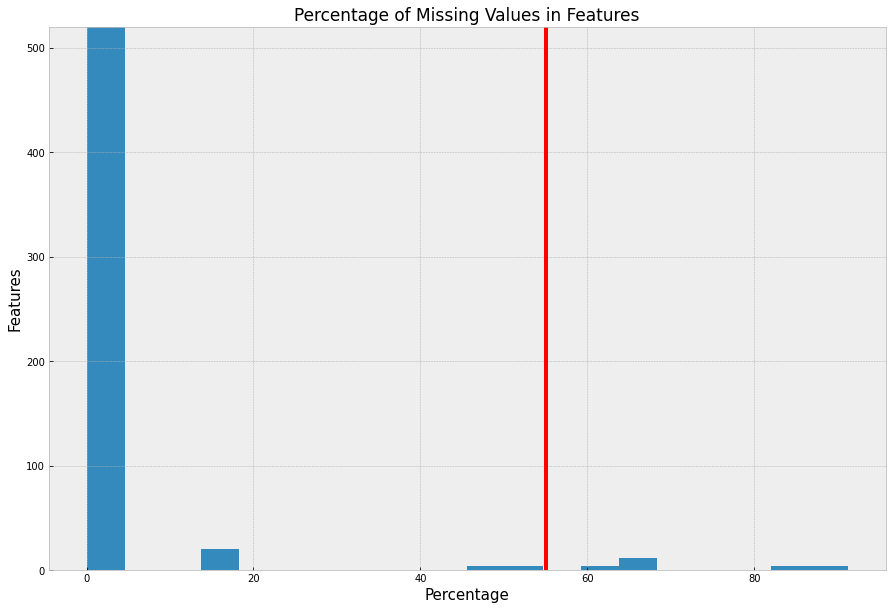

In [ ]:
# Get percentage of missing values
percent_missing = features_descriptives["PERCENTAGE_NA"]
percent_missing = pd.DataFrame({'percentage_missing_values': percent_missing})
# Create histogram of percentage of missing values in features
plt.style.use('bmh')
plt.figure(figsize=(15,10))
percent_missing.hist(bins=20)
plt.title('Percentage of Missing Values in Features',fontsize=17)
plt.ylabel('Features', fontsize=15)
plt.xlabel('Percentage', fontsize=15)
plt.plot([55, 55], [0, 540], 'k-', lw=4, color='red')
ax = plt.gca()
ax.set_ylim([0, 520])

In [ ]:
#Create bins for missing values
percent_na_bins = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
features_descriptives['PERCENTAGE_NA_BIN'] = pd.cut(
    features_descriptives['PERCENTAGE_NA'], percent_na_bins, right=False,
    include_lowest=True, 
    labels=["0%-5%","5%-10%","10%-15%","15%-20%","20%-25%",
            "25%-30%","30%-35%","35%-40%","40%-45%","45%-50%",
            "50%-55%","55%-60%","60%-65%","65%-70%","70%-75%",
            "75%-80%","80%-85%","85%-90%","90%-95%","95%-100%",])
#Frequency Distribution table of missing values
pd.crosstab(index=features_descriptives['PERCENTAGE_NA_BIN'], 
            columns='Frequency Distribution',
            colnames=['Percentage bin'],margins_name=False,dropna=False)

Percentage bin,Frequency Distribution
PERCENTAGE_NA_BIN,
0%-5%,539
5%-10%,0
10%-15%,0
15%-20%,20
20%-25%,0
25%-30%,0
30%-35%,0
35%-40%,0
40%-45%,0


In [ ]:
# Create function that counts columns with above certain % of NAs
def show_features_many_nulls(df, percentage):
    features_nulls = []
    for col in df.columns:
        percentage_nulls = 100 * (df[col].isna().sum() / len(df[col]))
        if (percentage_nulls > percentage):
            features_nulls.append(col)            
    return print(f"Features with more than {percentage}% of missing values",len(features_nulls))
#Test for 50% and 55% of missing values to see the difference in # of features   
print(show_features_many_nulls(secom_features, 50),"\n",show_features_many_nulls(secom_features, 55))

Features with more than 50% of missing values 28
Features with more than 55% of missing values 24
None 
 None


##Unique Values Analysis

In [ ]:
#Examine columns with unique values
unique_value = features_descriptives[(features_descriptives.UNIQUE_VALUES == 1)]
print("Number of columns with 1 unique value: ", unique_value.shape[0])
#How many of this columns sum 0?
unique_zero = unique_value[(unique_value.SUM == 0)]
print("Number of columns with 1 unique value and sum = 0: ", unique_zero.shape[0])
#Columns with unique values that do not sum 0
unique_off = unique_value[(unique_value.SUM != 0)]
unique_off

Number of columns with 1 unique value:  116
Number of columns with 1 unique value and sum = 0:  112


,FEATURE,COUNT,SUM,MEAN,MIN,Q1,MEDIAN,Q3,MAX,VARIANCE,STANDARD_DEV,UNIQUE_VALUES,MISSING_VALUES,PERCENTAGE_NA,OUTLIERS_3S,PERCENTAGE_O3S,P_VALUE,TEST_RESULT,NORM_STD,PERCENTAGE_NA_BIN
6,FEATURE_6,1553,155300.0,100.0,100.0,100.0,100.0,100.0,100.0,0.0,0.0,1,14,0.893427,0,0.0,1.0,NORMAL,NaN,0%-5%
43,FEATURE_43,1566,109620.0,70.0,70.0,70.0,70.0,70.0,70.0,0.0,0.0,1,1,0.063816,0,0.0,1.0,NORMAL,NaN,0%-5%
50,FEATURE_50,1566,1566.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1,1,0.063816,0,0.0,1.0,NORMAL,NaN,0%-5%
70,FEATURE_70,1561,1561.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1,6,0.382897,0,0.0,1.0,NORMAL,NaN,0%-5%


Text(0.5, 0, 'Unique values')

<Figure size 1080x720 with 0 Axes>

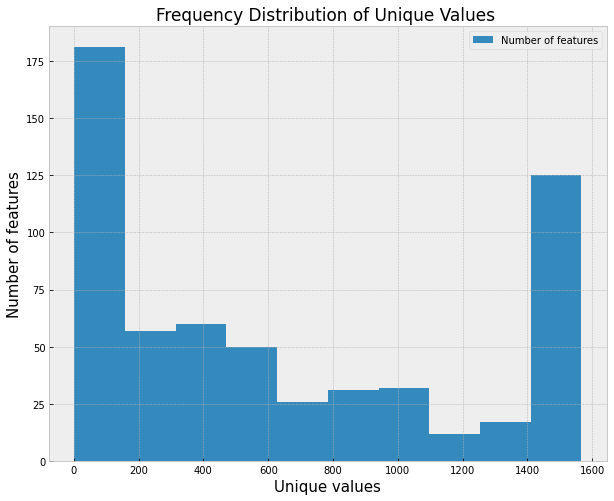

In [ ]:
#Unique values histogram
uni_values = features_descriptives["UNIQUE_VALUES"]
uni_values = pd.DataFrame({'Number of features': uni_values})
plt.figure(figsize=(15,10))
ax = uni_values.plot.hist(figsize=(10, 8),bins=10)
plt.title('Frequency Distribution of Unique Values ', fontsize=17)
plt.ylabel('Number of features', fontsize=15)
plt.xlabel('Unique values', fontsize=15)

## Outlier Analysis

In [ ]:
#Percentage of outliers per feature
#Add bins for missing values
percentage_Out3S_bins = [0,1,2,3,4,5,6,7,8]
features_descriptives['PERCENTAGE_OUT3S_BIN'] = pd.cut(
    features_descriptives['PERCENTAGE_O3S'], percentage_Out3S_bins, right=False,
    include_lowest=True, labels=["0%-1%","1%-2%","2%-3%","3%-4%",
                                 "4%-5%","5%-6%","6%-7%","7%-8%"])
#Frequency Distribution table of missing values
pd.crosstab(index=features_descriptives['PERCENTAGE_OUT3S_BIN'],
            columns='Frequency Distribution',colnames=['Percentage bin'],
            margins_name=False,dropna=False)

Percentage bin,Frequency Distribution
PERCENTAGE_OUT3S_BIN,
0%-1%,426
1%-2%,101
2%-3%,52
3%-4%,8
4%-5%,3
5%-6%,0
6%-7%,1
7%-8%,0


Text(0.5, 0, 'Outliers')

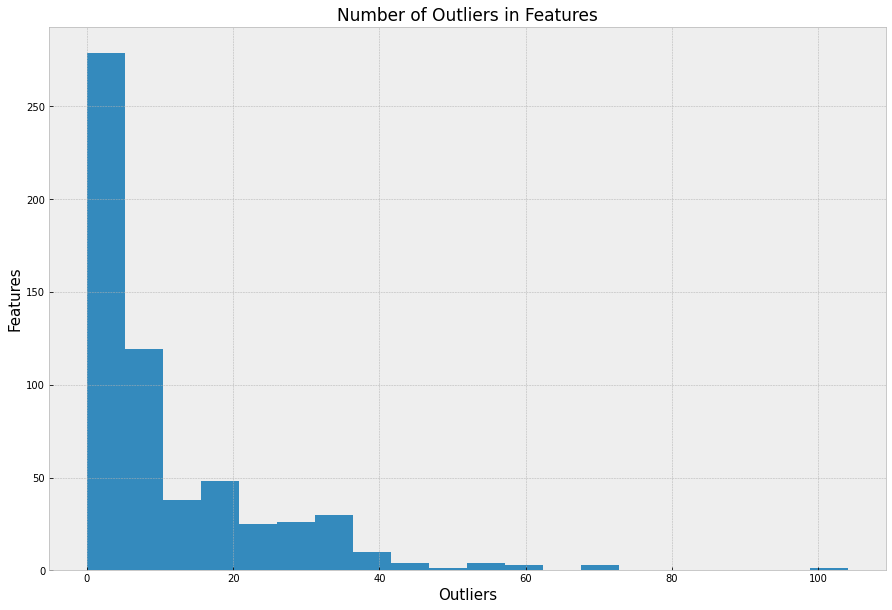

In [ ]:
# Outliers: Values outside the 3s bounds
outliers = features_descriptives["OUTLIERS_3S"]
# Create histogram of outliers in features
plt.figure(figsize=(15,10))
outliers.hist(bins=20)
plt.title('Number of Outliers in Features', fontsize=17)
plt.ylabel('Features', fontsize=15)
plt.xlabel('Outliers', fontsize=15)

#Volatility Analysis

(0.0, 25.0)

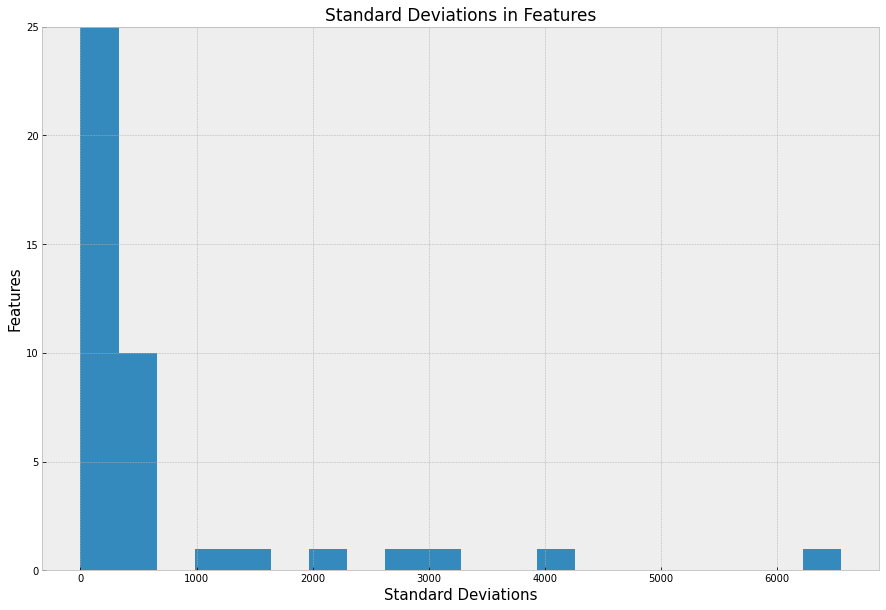

In [ ]:
# Volatility of features
volatility = features_descriptives["STANDARD_DEV"]
# Create histogram of standard deviation in features
plt.figure(figsize=(15,10))
volatility.hist(bins=20)
plt.title('Standard Deviations in Features', fontsize=17)
plt.ylabel('Features', fontsize=15)
plt.xlabel('Standard Deviations', fontsize=15)
ax = plt.gca()
ax.set_ylim([0, 25])

Text(0.5, 0, 'Scaled Standard Deviation')

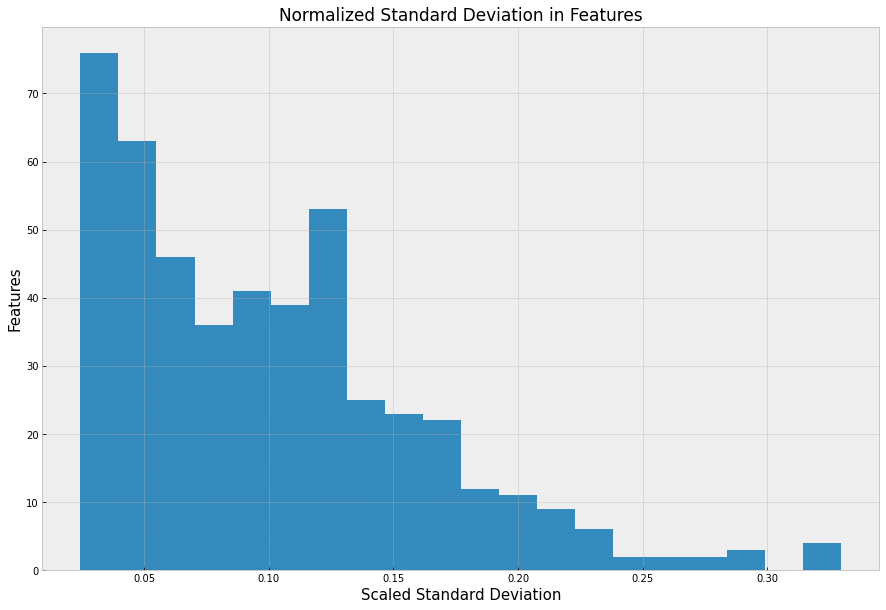

In [ ]:
# Volatility of features
volatility = features_descriptives["NORM_STD"]
# Create histogram of the standar deviation of normalized values in features
plt.figure(figsize=(15,10))
volatility.hist(bins=20)
plt.title('Normalized Standard Deviation in Features', fontsize=17)
plt.ylabel('Features', fontsize=15)
plt.xlabel('Scaled Standard Deviation', fontsize=15)

#Duplicate analysis

In [ ]:
#Identifying duplicates in rows and listing them
dups = pd.DataFrame(secom_data)
duplicateRowsDF = dups[dups.duplicated()]
print("Duplicate Cases per row (without TIMESTAMP): ", len(duplicateRowsDF))

Duplicate Cases per row (without TIMESTAMP):  0


In [ ]:
#Identifying duplicates in columns and listing them
dc = dups
# This function take a dataframe as a parameter and returning list of column
# names whose contents are duplicates.
def getDuplicateColumns(dc):
  # Create an empty set
  duplicateColumnNames = set()	
  # Iterate through all the columns of dataframe
  for x in range(dc.shape[1]):		
  # Take column at xth index.
    col = dc.iloc[:, x]	
    # Iterate through all the columns in DataFrame 
    # from (x + 1)th index to last index
    for y in range(x + 1, dc.shape[1]):			
    # Take column at yth index.
      otherCol = dc.iloc[:, y]			
      # Check if two columns at x & y index are equal or not,
      # if equal then adding to the set
      if col.equals(otherCol):
        duplicateColumnNames.add(dc.columns.values[y])				
  # Return list of unique column names whose contents are duplicates.
  return list(duplicateColumnNames)

# Driver code
if __name__ == "__main__" : 
    # List of Tuples
    columdup = secom_data
    # Create a DataFrame object
    dc = dups
    # Get list of duplicate columns
    duplicateColNames = getDuplicateColumns(dc)
    print('Number of duplicated columns: ', len(duplicateColNames))
    print('Duplicate Columns are :')
	  # Iterate through duplicate column names for column in duplicateColNames :
    # print('Column Name: ', column)
print(duplicateColNames)

Number of duplicated columns:  104
Duplicate Columns are :
['FEATURE_534', 'FEATURE_193', 'FEATURE_264', 'FEATURE_236', 'FEATURE_371', 'FEATURE_241', 'FEATURE_373', 'FEATURE_536', 'FEATURE_539', 'FEATURE_506', 'FEATURE_401', 'FEATURE_533', 'FEATURE_535', 'FEATURE_515', 'FEATURE_194', 'FEATURE_259', 'FEATURE_404', 'FEATURE_507', 'FEATURE_459', 'FEATURE_532', 'FEATURE_464', 'FEATURE_400', 'FEATURE_243', 'FEATURE_328', 'FEATURE_529', 'FEATURE_331', 'FEATURE_398', 'FEATURE_505', 'FEATURE_450', 'FEATURE_327', 'FEATURE_463', 'FEATURE_190', 'FEATURE_372', 'FEATURE_244', 'FEATURE_402', 'FEATURE_405', 'FEATURE_514', 'FEATURE_531', 'FEATURE_235', 'FEATURE_503', 'FEATURE_467', 'FEATURE_195', 'FEATURE_238', 'FEATURE_423', 'FEATURE_237', 'FEATURE_232', 'FEATURE_187', 'FEATURE_263', 'FEATURE_465', 'FEATURE_509', 'FEATURE_380', 'FEATURE_192', 'FEATURE_538', 'FEATURE_330', 'FEATURE_499', 'FEATURE_396', 'FEATURE_329', 'FEATURE_233', 'FEATURE_230', 'FEATURE_316', 'FEATURE_180', 'FEATURE_242', 'FEATURE_4

In [ ]:
#Identify duplicated columns
duplicatedf = secom_data[duplicateColNames]
duplicatedf_descriptives = descriptive_statistics(duplicatedf)
#Identify duplicated columns with one value and sum 0
dups_uniq = duplicatedf_descriptives[duplicatedf_descriptives.UNIQUE_VALUES == 1]
print("Number of duplicate columns with 1 unique value: ", dups_uniq.shape[0])
dups_sums_zero = duplicatedf_descriptives[duplicatedf_descriptives.SUM == 0]
print("Number of duplicate columns with 1 unique value and sum = 0: ", dups_sums_zero.shape[0])

Number of duplicate columns with 1 unique value:  104
Number of duplicate columns with 1 unique value and sum = 0:  104


## Frequency Distribution of Target Variable

Text(0.5, 0, 'Pass/Fail')

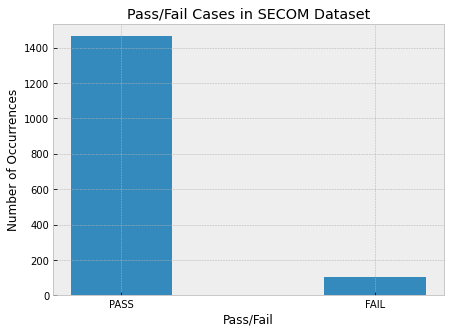

In [ ]:
# Frequency distribution of Pass/Fail Cases
pass_fail = secom_labels['STATUS'].value_counts()
pass_fail  = pass_fail .rename_axis('STATUS').reset_index(name='COUNTS')
pass_fail['STATUS'] = pass_fail['STATUS'].astype('int64')
pass_fail['STATUS'] = pass_fail['STATUS'].astype('category')
plt.figure(figsize=(7,5))
plt.style.use('bmh')
plt.bar(pass_fail['STATUS'], pass_fail['COUNTS'])
plt.title('Pass/Fail Cases in SECOM Dataset')
plt.xticks(pass_fail['STATUS'], ['PASS', 'FAIL'])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Pass/Fail', fontsize=12)

## Heatmap of Features

Text(0.5, 1.0, 'Correlation Heatmap')

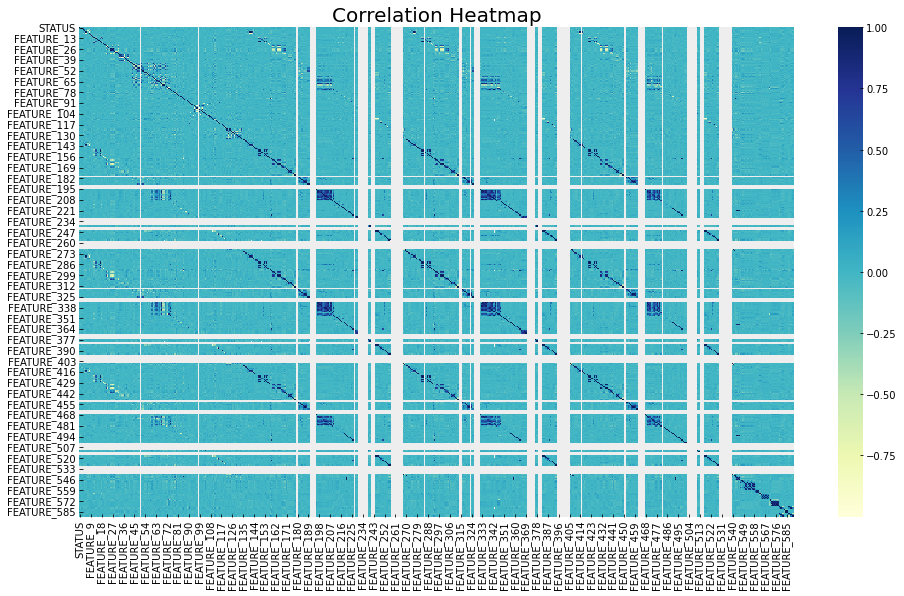

In [ ]:
#Heatmap of ALL Features in teh data set
plt.rcParams['figure.figsize'] = (16,9)
sns.heatmap(secom_data.corr(), cmap = "YlGnBu")
plt.title('Correlation Heatmap', fontsize = 20)

In [ ]:
#For exploratory purposes discriminate columns with mean, sum, max = 0 and 1 unique value
cleaner_features = features_descriptives.query("SUM != 0 | MAX != 0 | UNIQUE_VALUES != 1 | MEAN != 0")
clean_feature_list = cleaner_features["FEATURE"]
clean_features = secom_data[clean_feature_list]
#Analyze correlation of each feature against all the other features
corr_df = pd.DataFrame(columns=["FEATURE_A", "FEATURE_B", "CORRELATION"]) 
corrs = []
for col_name, col_name2 in combinations(clean_features, 2):
    correlation = clean_features[col_name].corr(clean_features[col_name2])
    corrlist = [col_name, col_name2, correlation]
    corr_length = len(corr_df)
    corr_df.loc[corr_length] = corrlist
corr_df.head(10)
##This cell takes time

,FEATURE_A,FEATURE_B,CORRELATION
0,STATUS,FEATURE_1,-0.025144
1,STATUS,FEATURE_2,-0.002615
2,STATUS,FEATURE_3,-0.000957
3,STATUS,FEATURE_4,-0.024631
4,STATUS,FEATURE_5,-0.013760
5,STATUS,FEATURE_6,NaN
6,STATUS,FEATURE_7,0.016244
7,STATUS,FEATURE_8,0.012993
8,STATUS,FEATURE_9,0.028018
9,STATUS,FEATURE_10,-0.031192


Text(0.5, 1.0, 'Most Correlated Features Heatmap')

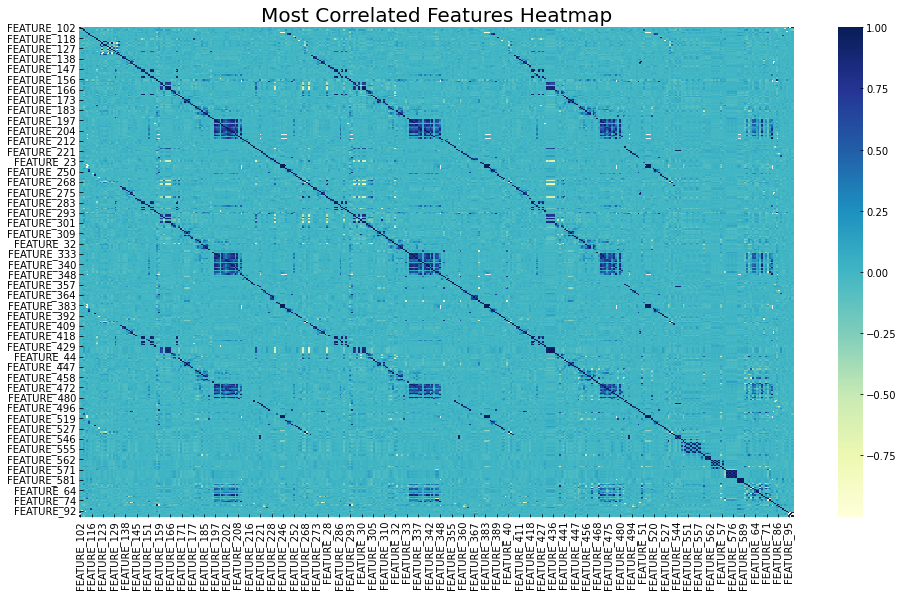

In [ ]:
#Identify most correlated combiantions of features
most_correlated_features = corr_df.query("CORRELATION > 0.5 | CORRELATION < -0.5")
most_correlated_features = most_correlated_features.query("CORRELATION < 0.99 & CORRELATION > -0.99")
most_correlated_features = most_correlated_features.reset_index()
most_correlated_features = most_correlated_features.drop(columns = "index")
#Create list of features that were in the most correlated pairs
features_a = most_correlated_features["FEATURE_A"].unique()
features_b = most_correlated_features["FEATURE_B"].unique()
features = np.concatenate([features_a , features_b])
features = np.unique(features)
#Create heatmap with most correlated features
most_corr_features = secom_data[features]
plt.rcParams['figure.figsize'] = (16,9)
sns.heatmap(most_corr_features.corr(), cmap = "YlGnBu")
plt.title('Most Correlated Features Heatmap', fontsize = 20)

## Splitting Data

In [ ]:
# Subset dataset between fail and pass, split and then concatenate to keep proportion
subset = secom_data.drop(columns = "TIMESTAMP")
# select pass cases
pass_df = subset[subset["STATUS"] == 1]
X_p = pass_df.iloc[:,1:]
y_p = pass_df.loc[:,"STATUS"]
# select fail cases
fail_df = subset[subset["STATUS"] == -1]
X_f = fail_df.iloc[:,1:]
y_f = fail_df.loc[:,"STATUS"]

#Split into test and train dataset 80% 20%
X_train_p,X_test_p,y_train_p,y_test_p = train_test_split(X_p, y_p, test_size=.2,
                                                         random_state=42)
X_train_f,X_test_f,y_train_f,y_test_f = train_test_split(X_f, y_f, test_size=.2,
                                                         random_state=42)
#Concatenate results
X_train = pd.concat([X_train_p, X_train_f], axis=0)
X_test = pd.concat([X_test_p, X_test_f], axis=0)
y_train = pd.concat([y_train_p, y_train_f], axis=0)
y_test = pd.concat([y_test_p, y_test_f], axis=0)

In [ ]:
#Examine proportions of train dataset
X_train = pd.concat([X_train, y_train], axis=1)
X_train.info()
Fail = X_train[X_train["STATUS"] == 1]
Pass = X_train[X_train["STATUS"] == -1]
print( "Fail cases: ", Fail["STATUS"].count(), "Pass cases: ", Pass["STATUS"].count())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1253 entries, 424 to 1208
Columns: 591 entries, FEATURE_1 to STATUS
dtypes: float64(590), int64(1)
memory usage: 5.7 MB
Fail cases:  83 Pass cases:  1170


In [ ]:
#Examine proportions of test dataset
X_test = pd.concat([X_test, y_test], axis=1)
X_test.info()
Fail = X_test[X_test["STATUS"] == 1]
Pass = X_test[X_test["STATUS"] == -1]
print( "Fail cases: ", Fail["STATUS"].count(), "Pass cases: ", Pass["STATUS"].count())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314 entries, 222 to 1392
Columns: 591 entries, FEATURE_1 to STATUS
dtypes: float64(590), int64(1)
memory usage: 1.4 MB
Fail cases:  21 Pass cases:  293


##Training dataset analysis

In [ ]:
train_features_descriptives = descriptive_statistics(X_train)
train_features_descriptives.head(5)

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1673: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


,FEATURE,COUNT,SUM,MEAN,MIN,Q1,MEDIAN,Q3,MAX,VARIANCE,STANDARD_DEV,UNIQUE_VALUES,MISSING_VALUES,PERCENTAGE_NA,OUTLIERS_3S,PERCENTAGE_O3S,P_VALUE,TEST_RESULT,NORM_STD
0,FEATURE_1,1251,3.770395e+06,3013.904620,2770.4000,2965.490000,3010.7100,3056.5350,3356.3500,5413.819560,73.578662,1224,2,0.159617,13,1.039169,1.0,NORMAL,0.125572
1,FEATURE_2,1248,3.116768e+06,2497.410561,2158.7500,2455.875000,2500.6350,2539.6400,2846.4400,6311.698408,79.446198,1211,5,0.399042,16,1.282051,1.0,NORMAL,0.115526
2,FEATURE_3,1242,2.733936e+06,2201.236400,2060.6600,2181.155500,2201.5833,2218.5778,2315.2667,877.442077,29.621649,475,11,0.877893,10,0.805153,1.0,NORMAL,0.116343
3,FEATURE_4,1242,1.734485e+06,1396.525694,0.0000,1081.822175,1285.2144,1588.5090,3715.0417,204875.317199,452.631547,486,11,0.877893,29,2.334944,1.0,NORMAL,0.121838
4,FEATURE_5,1242,6.105167e+03,4.915593,0.6815,1.020300,1.3168,1.5291,1114.5366,3969.226787,63.001800,474,11,0.877893,4,0.322061,1.0,NORMAL,0.056562


In [ ]:
#Count how many Features are Normally distibuted and not Normally distibuted
print("Normality Distribution of Features")
print(train_features_descriptives['TEST_RESULT'].value_counts())
# Overall number of missing values in the dataset
print("TOTAL OF VALUES: "   , X_train.isnull().sum().sum() 
                            + X_train.notnull().sum().sum(),
      "\nNOT NULL VALUES: " , X_train.notnull().sum().sum(),
      "\nMISSING VALUES:      ", X_train.isnull().sum().sum() ,
      "\nPERCENTAGE OF MISSING VALUES :",
      round((X_train.isnull().sum().sum()/(X_train.isnull().sum().sum() 
      + X_train.notnull().sum().sum()))*100, 2) , " %")
print(show_features_many_nulls(X_train, 50),"\n",show_features_many_nulls(X_train, 55))


Normality Distribution of Features
NORMAL        499
NOT NORMAL     92
Name: TEST_RESULT, dtype: int64
TOTAL OF VALUES:  740523 
NOT NULL VALUES:  706895 
MISSING VALUES:       33628 
PERCENTAGE OF MISSING VALUES : 4.54  %
Features with more than 50% of missing values 28
Features with more than 55% of missing values 24
None 
 None
